## Regresión logística

**Propósito:** En el desarrollo de este cuaderno se espera aprender más sobre la regresión logística y la interpretación de sus coeficientes. Se hará una introducción a las pruebas de hipótesis de la regresión y la validación del modelo para evaluar su desempeño en tareas de clasificación

**Contexto del problema** Se toma un conjunto de datos de [LendingClub (LC) Statistics](https://www.lendingclub.com/info/download-data.action) y contiene registro de prestamos emitidos entre 2007 y 2012 junto al estado del préstamo (pagado o en deuda). Hay ~50 variables, pero para fines prácticos se realiza una preselección de variables como: ingresos anuales, propiedad de vivienda, etc. Nuestro propósito será construir un modelo que permita clasificar o pronosticar si un nuevo cliente será moroso o no.

El cuaderno esta estructurado de la siguiente manera:

1. Explorar el conjunto de datos suministrado para conocer mejor cada una de las variables
2. Revisar posibles efectos de confusión
3. Aprender los elementos básicos de la regresión logística
4. Evaluar y comparar el desempeño de la regresión logística

### Importar módulos/ paquetes

In [44]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
from statsmodels.formula.api import ols

from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold


from IPython.display import display_html

## 0. Cargar y preparar conjunto de datos para ajuste del modelo de regresión

In [3]:
# Importar conjunto de datos
loc = "data/Lending_club_cleaned_2.csv"
df = pd.read_csv(loc)

In [4]:
# Se asigna el tipo de variable categórica según corresponda

categories = ['loan_status', 'verification_status', 'emp_length','home_ownership',
              'term', 'grade']

df[categories] = df[categories].astype("category")

# La variable init rate se toma como objecto debido a que esta en la forma ".xx%"
# Se remueve el "%" y se transforma a tipo flotante

df.int_rate = df.int_rate.str.rstrip('%').astype('float')

In [5]:
df.shape # Forma del conjunto de datos

(38705, 10)

In [6]:
df.head(10) # Primeras 10 observaciones

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,Fully Paid,36000.0,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,Fully Paid,47004.0,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,Fully Paid,48000.0,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,Charged Off,40000.0,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,Charged Off,15000.0,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


Se cuentan con 38706 registros de transacciones pasadas. Cada registro corresponde a una solicitud aprovada. La primera columna indica si el beneficiario pagó el total del prestamo (Fully paid) o no (Charged Off). La descripción de cada columna (variable) se da a continuación:

|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indica si los ingresos fueron verificados, no verificados, o si la fuente de ingresos se verificó                                         |
|      emp_length     |                       Experiencia laboral. 0 significa 1 año o menos de experiencia, mientras que 10 son 10 o más años.                      |
|    home_ownership   |             Estatus de propiedad de vivienda, información suministrada por el beneficiado o el reporte de crédito. Sus valores son: Renta, propia, hipoteca, otro            |
|       int_rate      |                                                                           Tasa de interés del préstamo                                                                          |
|      loan_amnt      | Valor solicitado por el beneficiado. Si se reduce el valor prestado se refleja en este valor |
|       purpose       |                                                           Información suministrada por el beneficiario del préstamo.                                                          |
|         term        |                                             Número de pagos del crédito. Los valores son mensuales, pueden ser de 36 o 60 meses.                                             |
|        grade        |                                                                            Grado asignado al préstamo                                                                          |

## 1. Análisis exploratorio

### 1.1 Relación entre el estatus y otras variables

Previo a la realización de cualquier tipo de análisis sofisticado es importante entender el comportamiento de las variables y posibles relaciones entre ellas. En este conjunto de datos se cuentan con variables continuas y categóricas, especificamente se revisa la relación de la variable estatus vs las variables continuas `annual_inc`, `int_rate` y `loan_amnt`

<IPython.core.display.Javascript object>


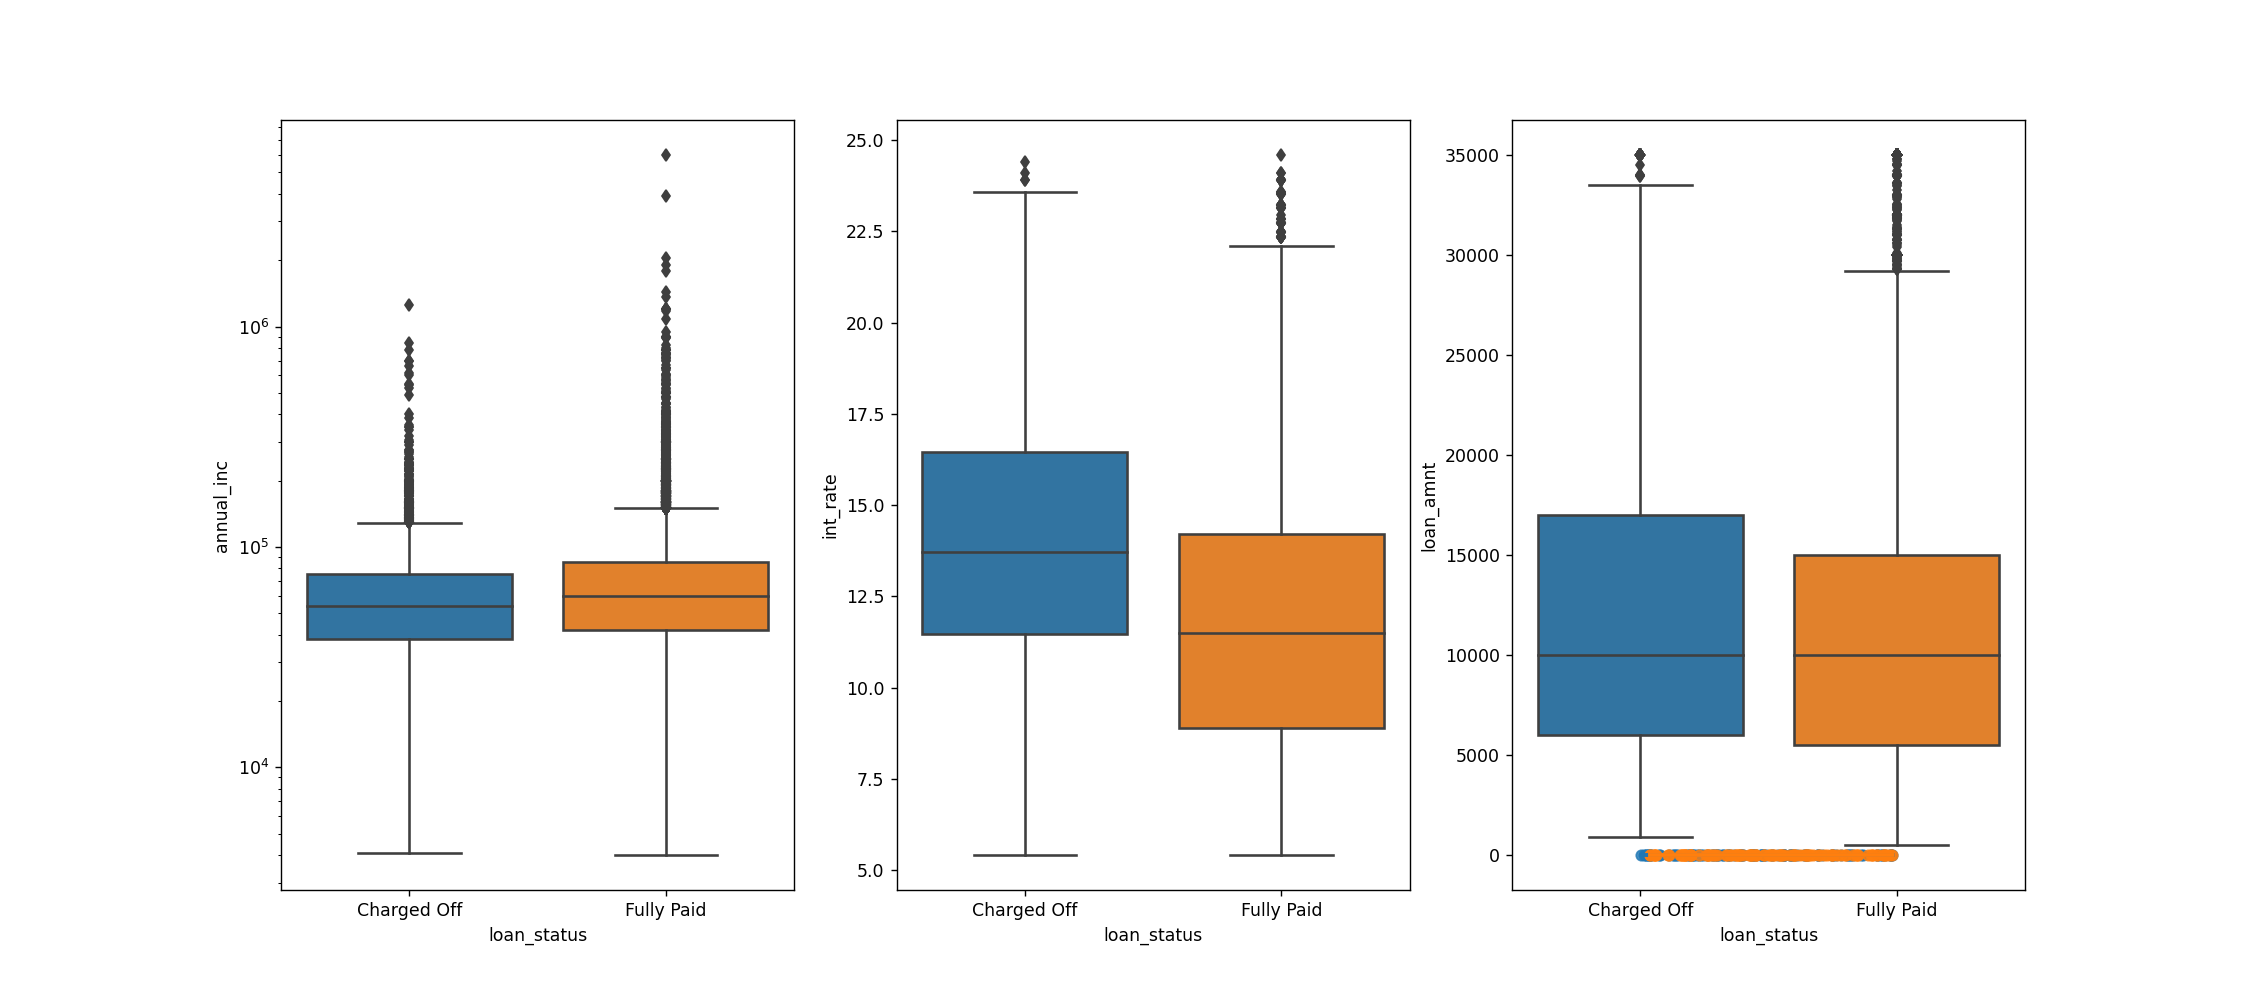

In [7]:
# Visualización utilizando Seaborn

fig, ax = plt.subplots(1,3, figsize=(18,8)) # Se crea figura de una fila y tres columnas

sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='int_rate', x ='loan_status', data = df, ax=ax[1])
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[2]);

**Pregunta 1:** ¿Que afirmaciones se pueden hacer de acuerdo a los diagramas de caja?

**Pregunta 2:** Dada la siguiente afirmación: "A partir de los gráficos se puede concluir que los ingresos mensuales juegan un papel fundamental en el pago de las obligaciones financieras"

 - ¿Cree que esta afirmación es correcta? Justifique su respuesta, ¿Como se podría verificar? 

In [18]:
# Se realiza una prueba t para comparar ambas muestras

a = df[df['loan_status']=="Charged Off"]['annual_inc']
b = df[df['loan_status']=="Fully Paid"]['annual_inc']
T,p = ttest_ind(a,b)
print("Valor p: %.3f" %(p))

Valor p: 0.000


Con un nivel de significancia del 5% existe evidencia para rechazar la hipótesis nula, es decir, los ingresos medios son diferentes para ambas muestras

En el caso de las variebles categóricas, la comparación se puede realizar utilizando tablas de contigencia o frecuencias. Una prueba chi-cuadrado es útil para verificar si las relaciones observadas son estadísticamente diferentes. A continuación se muestra como construir una tabla de contingencia para `loan_status` y `verification_status`

In [19]:
# Función para crear tablas de contigencia

def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)      # Argumento a introducir... variable a cruzar
    ct_res['Fully Paid(%)'] = round( ct_res['Fully Paid']/ct_res['All']*100, 2)  # Crea una columna para % en las filas
    return ct_res.drop(columns='All')

get_ct(df,"verification_status")

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


**Pregunta 3:** Considerando los resultados de la tabla de contingencia, ¿Es posible afirmar que es necesario verificar la fuente de ingresos de los solicitantes?

In [20]:
# Uso de la prueba chi-cuadrado para verificar la asociación entre `loan_status` y `verification_status`

chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['verification_status'], columns=df['loan_status']))
print('verification_status: el valor-p de la prueba chi es %.4f' %p)

verification_status: el valor-p de la prueba chi es 0.0000


Una vez más tenemos evidencia para afirmar que existen diferencias significativas, esta vez para el estatus y la verificación de los ingresos.

**Argumente si la siguiente afirmación es correcta:** "Dado que hay evidencia significativa entre los usuarios que no han sido verificados y los usuarios que si han sido verificados, entonces deberíamos siempre hacer la verificación "

### 1.2 Tablas de contingencia estratificadas de verificación y estatus del pago

Como se vió en la sección anterior, es preciso mejorar la compresión de otras variables para evitar posibles confusiones en el impacto. Si deseamos saber si el estatus de verificación esta realmente asoiciado con el estatus de pago, se debería considerar una tabla de contingencia estratificada por otras variables tambien relacionadas

A continuación se muestra la construcción de una función para incluir estratos a la tabla de contingencia

In [21]:
# El argumento de la fucnión será la variable categórica que estratificará la tabla de contingencia 
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var, df.verification_status], columns = df.loan_status, margins = True)
    ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
    return ct_stra.drop(columns='All').drop('All', level=0)

In [22]:
get_ct_stra(df.home_ownership) # Estratificación según el estado de vivienda

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22

In [23]:
get_ct_stra(df.term)  # Estratificación con el término del préstamo

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

Se puede ver que se conserva la tendencia cuando se hace la estratificación por `home_ownership`. El porcentaje de usuarios al día desciende a medida que el estatus de verificación se vuelve menos confiable, independientemente de la variable `home_ownership`. 

En cuanto a la variable `term` La tendencia ya no se conserva en ambos niveles . Podemos ver que la proporción de usuarios totalmente pagados con un plazo de préstamo más corto (36 meses) permanece igual en los diferentes niveles de "estado de verificación" en alrededor del 88%.

In [24]:
pd.crosstab(df['term'], df['verification_status'])

verification_status,Not Verified,Source Verified,Verified
term,,,
36 months,14154,6820,7310
60 months,2345,2999,5077


## 2. Información adicional a partir de una regresión lineal

A partir de las pruebas de hipótesis se ha pensado que la probabilidad de pago aumenta cuando menos verificación se hace a información de los ingresos. Sin embargo, esta observación no puede ser verificada directamente por la prueba de hipótesis.

Como una primera aproximación, se podría crear un modelo lineal para explicar el estatus del préstamo usando las variables del conjunto de datos. Recuerde que esta variable es de tipo categórico, por lo que es necesario tranformarla. Además, las variables `verification_status`, `grade` y `term` son ordinales, así que se podrían usar asumiendo que la distancia entre clases es igual. Finalmente, con el propósito de evitar que grandes números aparezcan en los coeficientes de regresión se realiza una normalización de los datos numéricos.

In [25]:
df2 = df.copy()   # Se copia el conjunto de datos para evitar hacer modificaciones

var_names = ['loan_status','verification_status','grade','term']   # Variables independientes ordinales
for var in var_names:
    df2[var] = df2[var].cat.codes                                  # Codificación
    
var_names2=['annual_inc','int_rate','loan_amnt']                   # Variables independientes continuas
for var in var_names2:
    df2[var] = (df2[var]-df2[var].mean())/df2[var].std()           # Normalización

Consideremos un primer modelo lineal usando las variables `annual_inc`, `verification_status`, `loan_amnt`, `int_rate` y `term`

In [26]:
model1 = 'loan_status ~ verification_status + annual_inc + loan_amnt + int_rate + term'
lm1   = sfm.ols(formula = model1, data = df2).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     385.5
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:43:18   Log-Likelihood:                -13075.
No. Observations:               38705   AIC:                         2.616e+04
Df Residuals:                   38699   BIC:                         2.621e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8763    

**Pregunta 4:** ¿Que desventaja hay al usar la regresión lineal para este caso?

In [27]:
p = np.random.rand(100)
x = np.random.rand(100)
y = np.logical_or(np.logical_and(x<=0.5, p>0.8), np.logical_and(x>0.5, p<=0.8)).astype(int)

sns.regplot(x, y);

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


### 3. Regresión logística: Modelos lineales generalizados

<div style="text-align: justify"> 
La regresión logística a diferencia de la regresión lineal no busca predecir un valor numérico, sino que determina la probabilidad de pertenecer de una categoría de acuerdo a los valores de las variables independientes. Otro elemento que diferencia a estas dos regresiones es el supuesto de normalidad, donde la regresión logística estima la probabilidad de ocurrencia de un acontecimiento siguiendo una distribución de probabilidad binomial. Antes que nada es importante entender que son los <b>odds</b>, es la razón entre la probabilidad de éxito y la probabilidad de fracaso <br>
    
$$odds=\frac{\text{Probabilidad de éxito}}{\text{Probabilidad de fracaso}} = \frac{p}{1-p}$$
    
La regresión logística se basa en el logaritmo natural de este cociente, como se muestra en la ecuación, en la que los valores positivos de beta aumentan la probabilidad de ocurrencia
</div>
    
$$\ln(\frac{P}{1-P})= \beta_{0} +\beta_{1}x_{1}+\beta_{2}x_{2}+\beta_{3}x_{3} $$



Veamos ahora como podríamos usar la librería stasmodels para modelar el status de pago usando la regresión logística

In [37]:
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])   # Sub conjunto de datos para dos variables
df_log1['verification_status'] = df.verification_status.cat.codes       # Codificación de variable ordinal
df_log1['loan_status'] = df.loan_status.cat.codes                       # Codificación del estatus de pago
df_log1['Intercept'] = 1                                                # Columna para intercepto

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Oct 2021   Pseudo R-squ.:                0.002350
Time:                        10:04:38   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
verification_status    -0.1460      0.017     -8.600      0.000      -0.179      -0.113
=======================================================================================
"""

### 3.1 Interpretación de los coeficientes

Aunque la regresión logística es relativamente más compleja que la regresión lineal, los signos de los coeficientes de regresión siguen representando la dirección de la influencia de una variable específica: Un coeficiente positivo significa la influencia favorable sobre la variable dependendiente asociado con la variable independiente, y vice-versa

Otra parte importante es la interpretación de los valores p de los coeficientes de regresión. <i>Recuerde que el valor p indica la probabilidad de ver un valor tan extremo como el estadístico de prueba </i>. La hipótesis que se prueba es: 

$$
H_0: \beta = 0~vs.~ H_A: \beta \neq 0.
$$

En caso de no rechazar la hipótesis nula, se dice que existe evidencia para afirmar que la variable independiente asociada es significativa o importante

Para nuestro ejemplo, los resultado de la tabla sugieren que cuando `verfication_status` incrementa en 1, los odd de los pagos decrece en un 14%. Ahora, dado que el valor p del coeficiente es menos al 5%, se concluye que es significativo y el decrecimiento no se debe a causas aleatorias.

Otra salida igualmente importante es `Pseudo R-squ.` Esta métrica es similar al $R^2$ para lo modelos lineales, es decir, el porcentaje de variabilidad explicada por el modelo propuesto

### Interpretación geométrica de la regresión logística

Aunque la regresión logística explica la probabilidad de pertenecer a una clase, facilmente se puede transformar en un clasificador al elegie una **Frontera de decisión**. Se toma un valor de c que permita hacer la clasificación así:

> if $\beta_0 + \beta_1*\text{verification_status} > c$ entonces: Fully Paid; o

> if $\beta_0 + \beta_1*\text{verification_status} \leq c$ entonces: Charged Off

La curva definida por la ecuación  $\beta_0 + \beta_1$ `verification_status` $=\log\left(\frac{p}{1-p}\right)$ permite diferenciar a los morosos de los no morosos. Por ejemplo, si la probailidad de pertenecer a un grupo o al otro es de 0.5, la frontera de decisión estará dada por el valor:

> Un usuario será clasificado como no moroso si: $\text{verification_status} >\frac{-\beta_0}{\beta_1}\approx 13.334931506849317$

> Un usuario será clasificado como moroso si: $\text{verification_status} \leq \frac{-\beta_0}{\beta_1}\approx 13.334931506849317$

Ahora, se necesita determinar que valor de probabilidad $p$ nos da una mejor clasificación

**Ejercicio:** Pruebe una regresión logística para la variable `loan_status` usando ahora como regresores `loan_amnt` y `int_rate`. Normalice ambas variables antes de correr el modelo

In [29]:
df6 = df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt'] = (df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std() # Normalización de loan_amnt
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()       # Normailzación de int_rate
df6['Intercept'] = 1                                                                 # Intercepto

logit2 = sm.Logit(df6['loan_status'], df6[['Intercept','loan_amnt','int_rate']])     # Ajuste de la regresión
logit_res2 = logit2.fit()
logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.386118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Oct 2021   Pseudo R-squ.:                 0.04888
Time:                        08:43:27   Log-Likelihood:                -14945.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9277      0.016    119.842      0.000       1.896       1.959
loan_amnt      0.0399      0.015      2.664      0.008       0.011       0.069
int_rate      -0.5862      0.016    -36.901      0.000      -0.617      -0.555
==============================================================================
"""

<IPython.core.display.Javascript object>


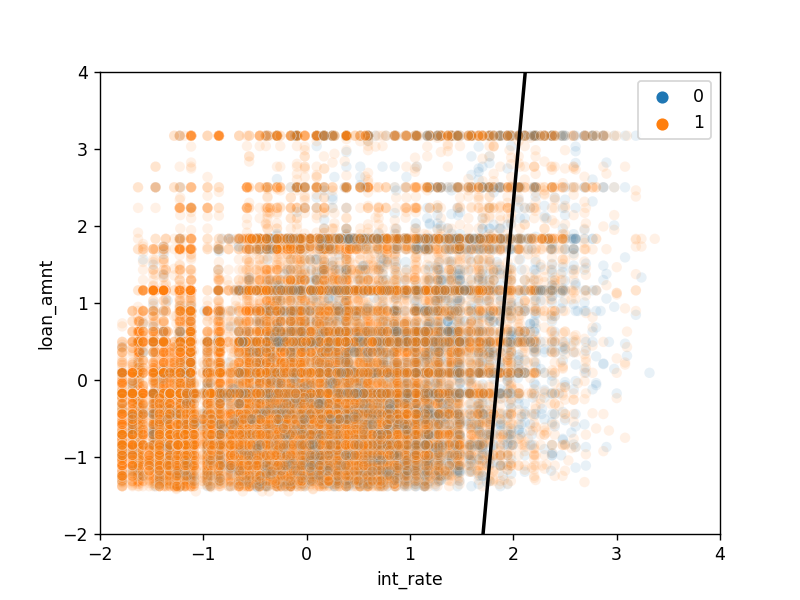

interactive(children=(FloatSlider(value=0.7, description='p', max=0.99, min=0.01, step=0.01), Output()), _dom_…

In [30]:
b_Intercept = 1.9277 
b_loan_amnt = 0.0399 
b_int_rate = -0.5862 


import ipywidgets as widgets
from ipywidgets import interact
%matplotlib notebook

fig, ax = plt.subplots()
sns.scatterplot(x='int_rate', y='loan_amnt', hue='loan_status', data=df6, alpha=0.1, ax=ax)
plt.xlim(-2,4)
plt.ylim(-2,4)
plt.legend()


p = 0.7
x1 = np.arange(-2, 40, 3)
y1 = (1/b_loan_amnt)*(np.log(p/(1-p))-b_Intercept-b_int_rate*x1)
l, = plt.plot(x1, y1, lw=2, color='k', label='Current Decision boundary')

def update(p=0.7):
    y1=(1/b_loan_amnt)*(np.log(p/(1-p))-b_Intercept-b_int_rate*x1)
    l.set_ydata(y1)
    fig.canvas.draw_idle()

interact(update, p=widgets.FloatSlider(value=p,min=0.01,max=0.99,step=0.01));

### 3.2 Evaluación del modelo de regresión logística

Para evaluar el desempeño de la regresión logística resolviendo una tarea se presta atención en si ha realizado las clasificaciones como se esperaría. Ahora, ¿Cómo se podría hacer si la regresión logística pronostica probabilidades y queremos las etiquetas?

Una opción es dar un valor de referencia para las probabilidades pronosticadas, de modo que si están por encimo o debajo toman un valor de la etiqueta y luego comparar con los valores reales y medir su precisión.

**Pregunta 5:** ¿Cuál sería la mejor manera para determinar este punto de corte/referencia?

Una manera de hacer es con el concepto de `tasa de verdaderos positivos` (TPR) y ` tasa de verdaderos negativos` (TNR). Para nuestro contexto, TPR mide la proporción de personas que pagaron sus obligaciones y fueron correctamente identificadas por nuestro modelo, mientras que TNR mide la proporción de morosos correctamente clasificados.

Es un reto encontrar un punto o condición que alcance valores altos de TPR Y TNR al midmo tiempo. Se podría prioriza sobre uno de ellos basado en un escenario en particular, por ejemplo, TNR is usualmente más importante que TPR para poder evitar hacer prestamos a posibibles deudores en vez de identificar buenos candidatos.

In [31]:
# Cálculo de TPR Y TNR considerando los puntos de referencia p = 0.8, 0.85, 0.9 

b_Intercept = 1.9277 
b_loan_amnt = 0.0399 
b_int_rate = -0.5862 

def rates(p):
    a = df6.loan_status
    b = (b_Intercept + b_loan_amnt*df6['loan_amnt'] + b_int_rate*df6['int_rate'] > np.log(p/(1-p))).astype('int')
    
    TPR = (a & b).sum(axis=0)/a.sum(axis=0)
    TNR = (1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

print('p=0.8 ',rates(0.8))
print('p=0.85 ',rates(0.85))
print('p=0.9 ', rates(0.9))

p=0.8  [0.8393506688711859, 0.33400735294117645]
p=0.85  [0.6668570569667819, 0.5494485294117647]
p=0.9  [0.35484743724635504, 0.8457720588235295]


Se observa que con un valor de $p = 0.8$ se obtiene el valor más alto de TPR y menor de TNR. Esto significa que se hará una buena clasificación de "buenas pagas", pero no para posibles morosos. Por otro lado, $p = 0.9$ detectará de manera adecuada una buena proporción de morosos, dejando de clasificar a buenos clientes y dejando que se vayan con otros prestamistas.

En cuanto a $p = 0.85$ se da un punto medio de clasificar correctamente al 66% de buenos clientes y 54% de morosos

### 3.3 Curvas características de operación del receptor (ROC)

Es de gran ayuda el uso de TPR y TNR para elegir el punto de referencia para la clasificación de los clientes. No obstante, resulta engorroso tener que evaluar múltiples valores para evaluar la precisión del pronóstico. En es te punto se da la motivación para las **curvas de operación recptivas o ROC"

ROC relaciona de forma gráfica a TPR y TNR e ilustra como se comporta la regresión logística en la medida que el punto de referencia cambie. A continuación se muestra una curva ROC para el ejemplo.

<IPython.core.display.Javascript object>


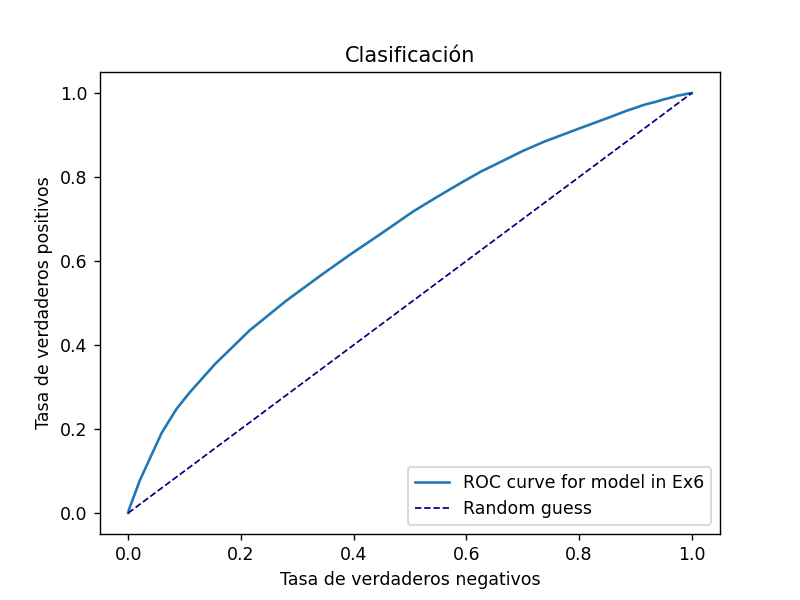

In [35]:
# De nuevo se define la función para calcular TPR y TNR

def rates(p):
    a= df6.loan_status
    b=(b_Intercept+b_loan_amnt*df6['loan_amnt']+b_int_rate*df6['int_rate']>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

#Se usa la función para ajustar los valores de la curva
x=[]
y=[]
for p in np.arange(0.01,0.99,0.01):
    z = rates(p)
    y.append(z[0])
    x.append(1-z[1])
    
fig, ax = plt.subplots()

ax.plot(x,y, label=f'ROC curve for model in Ex6')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.xlabel('Tasa de verdaderos negativos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Clasificación')
plt.legend(loc='lower right');

**Ejercicio** Construya una curva ROC para comparar dos propuestas de modelo para la clasificación

<IPython.core.display.Javascript object>


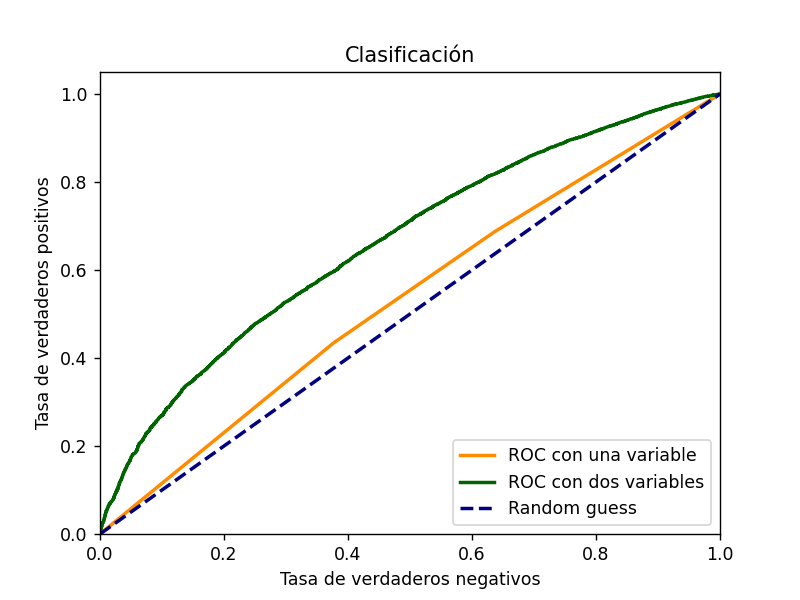

In [38]:
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']]) # Usar los modelos ya ajustados para pronosticar
predict_2_p = logit_res2.predict(df6[['Intercept','loan_amnt','int_rate']])
roc_p = roc_curve(df_log1['loan_status'], predict_p)                        # Uso de la librería de sklearn
roc_2_p = roc_curve(df6['loan_status'], predict_2_p)                        

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=line_width, label=f'ROC con una variable')
plt.plot(roc_2_p[0], roc_2_p[1], color='darkgreen',
         lw=line_width, label=f'ROC con dos variables')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de verdaderos negativos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Clasificación')
plt.legend(loc='lower right')
plt.show()

### Comparación de los modelos usando el área bajo la curva

Una manera de resumir las curvas ROC es computando el área bajo la curva **(AUC)**

Si AUC es cercano a uno, entonces la elección es perfecta. La curva ROC para elección aleatoria es la línea diagonal del gráfico, y usualmente, se toma como línea base para comparar si la clasificación del modelo aprendido se debe a los datos o es puramente aleatoria. El cálculo de **AUC** se puede realizar usando el módulo de `sklearn.metrics`:


In [42]:
auc_p = auc( roc_p[0], roc_p[1] )
auc_2_p = auc( roc_2_p[0], roc_2_p[1] )

print('AUC de Una sola variable: ', auc_p)
print('AUC de dos variables: ', auc_2_p)

AUC de Una sola variable:  0.5340366188185781
AUC de dos variables:  0.661552829440058


## Matriz de confusión

In [56]:
predict_2_p = logit_res2.predict(df6[['Intercept','loan_amnt','int_rate']])
predict_2_p = (predict_2_p>0.85).astype("int")
real_value = df6['loan_status']

print(confusion_matrix(real_value.astype("int"), predict_2_p))                # Imprimir la matriz de confusión
print(classification_report(real_value.astype("int"), predict_2_p))           # Imprimir un reporte de clasificación

[[ 2989  2451]
 [11082 22183]]
              precision    recall  f1-score   support

           0       0.21      0.55      0.31      5440
           1       0.90      0.67      0.77     33265

    accuracy                           0.65     38705
   macro avg       0.56      0.61      0.54     38705
weighted avg       0.80      0.65      0.70     38705



## Conclusión

En este cuaderno se hizo una introducción a la **Regresión logística** y como puede ser utilizado para realizar clasificaciones. El trabajo realizado se resume en:

1. Realizar un análisis exploratorio de datos
2. Realizar pruebas de hipótesis
3. Uso de la regresión logística y evaluación de hipótesis
4. Evaluar la clasificación usando curvas AUC y matriz de confusión

La regresión extiende el concepto de la regresión lineal clásica y permite desarrollar tareas de clasificación. La interpretación de los coeficientes se da de manera similar